In [10]:

import json

path = '/home/us441/nvidia-collab/vlad/results/refactored_test/vanilla/seed=2/evaluation_results/epoch=80.ckpt/evaluation_results.json'

def load(path):
    with open(path, 'r') as f:
        d = json.load(f)
    return d

In [11]:
d = load(path)

In [3]:
from matplotlib import pyplot as plt


In [4]:
%matplotlib inline

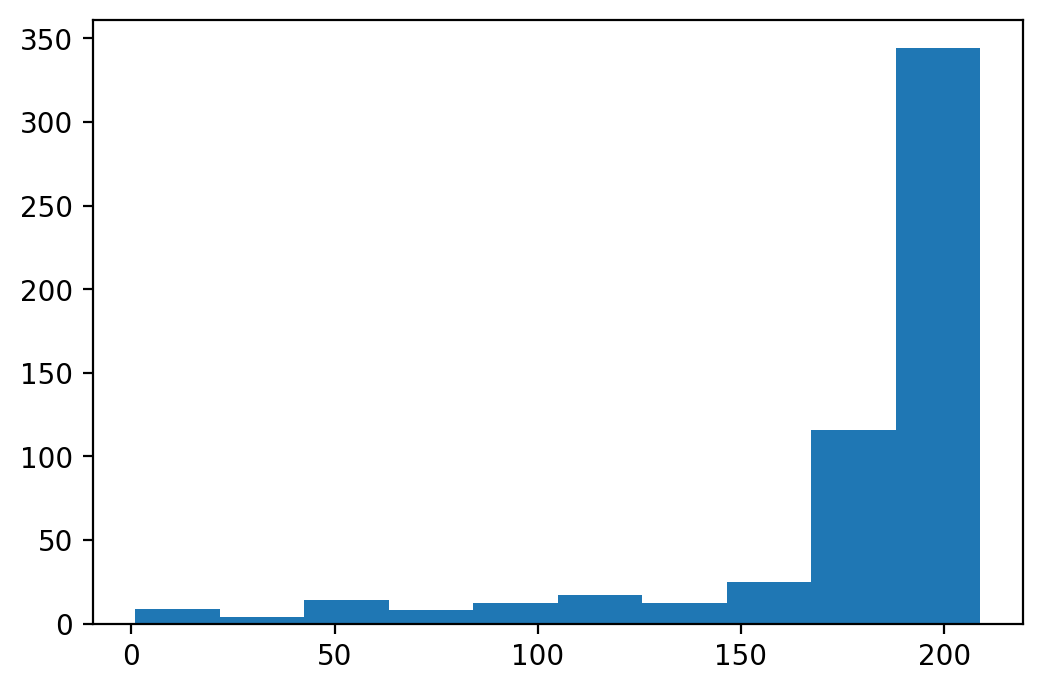

In [9]:
plt.figure(dpi=200)
plt.hist([v['distance_travelled'] / 6.4865 for _, v in d['results_per_episode'].items()])
plt.show()

In [6]:
24 / 3.

6.486486486486486

In [15]:
path_2 = '/home/us441/nvidia-collab/vlad/results/refactored_test/best_grid_km_taper_curled_3/seed=1/evaluation_results/epoch=39_success_rate=0.68.ckpt/evaluation_results.json'
d_2 = load(path_2)

In [16]:
d_2

{'results_per_episode': {'0': {'time_travelled': 100,
   'distance_travelled': 1152.884765625,
   'road_completed': 1,
   'off_screen': True,
   'has_collided': False,
   'index': 0},
  '1': {'time_travelled': 101,
   'distance_travelled': 1131.5665283203125,
   'road_completed': 1,
   'off_screen': True,
   'has_collided': False,
   'index': 1},
  '2': {'time_travelled': 48,
   'distance_travelled': 383.68939208984375,
   'road_completed': 0,
   'off_screen': False,
   'has_collided': True,
   'index': 2},
  '3': {'time_travelled': 119,
   'distance_travelled': 1246.73876953125,
   'road_completed': 1,
   'off_screen': True,
   'has_collided': False,
   'index': 3},
  '4': {'time_travelled': 353,
   'distance_travelled': 1291.416748046875,
   'road_completed': 1,
   'off_screen': True,
   'has_collided': False,
   'index': 4},
  '5': {'time_travelled': 48,
   'distance_travelled': 311.8514404296875,
   'road_completed': 0,
   'off_screen': False,
   'has_collided': True,
   'index': 5

<Figure size 1200x800 with 0 Axes>

<Figure size 432x288 with 0 Axes>

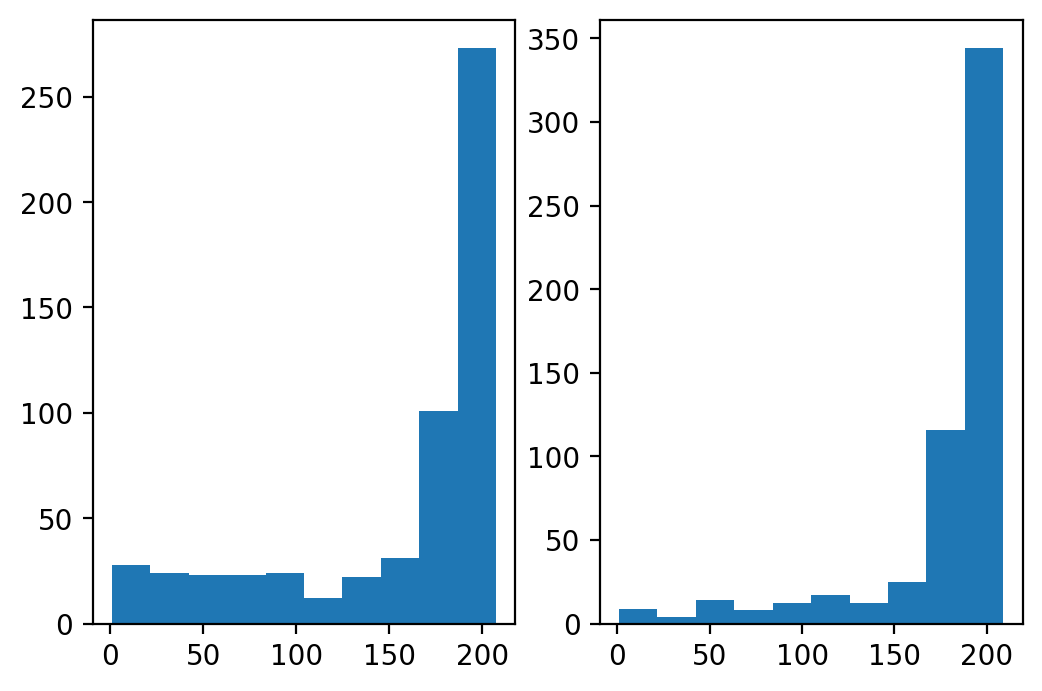

In [20]:
plt.figure(dpi=200)
plt.subplot(121)
plt.hist([v['distance_travelled'] / 6.4865 for _, v in d_2['results_per_episode'].items()])
plt.subplot(122)
plt.hist([v['distance_travelled'] / 6.4865 for _, v in d['results_per_episode'].items()])
plt.show()

In [23]:
import os
import argparse
import yaml
import json

import torch

from torch.utils.tensorboard import SummaryWriter

In [24]:
def get_success_rate(path):
    json_path = os.path.join(path, "logs.json")
    with open(json_path, "r") as f:
        logs = json.load(f)
    for log in logs["logs"]:
        if "success_rate" in log:
            return log["success_rate"]
    if "custom" in logs:
        if "success_rate" in logs["custom"]:
            return logs["custom"]["success_rate"][0]
    return None

In [25]:
def get_hparams(path):
    yaml_path = os.path.join(path, "hparams.yaml")
    with open(yaml_path, "r") as f:
        hparams = yaml.load(f, Loader=yaml.Loader)
    return hparams

In [162]:
import numpy as np
def get_results(path):
    success_rate = get_success_rate(path)

    ckpt_path = os.path.join(path, 'last.ckpt')
    if not os.path.exists(ckpt_path):
        return None, None
    x = torch.load(ckpt_path)

    # hparams = get_hparams(path)
    hparams = x['hyper_parameters']

    hparams_to_report = hparams["cost_config"]
    hparams_to_report["seed"] = hparams["training_config"]["seed"]
    hparams_to_report["lr"] = hparams["training_config"]["learning_rate"]
    for key in hparams_to_report:
        try:
            if not 'masks' in key and key != 'seed' and key != 'agg_func_str':
                hparams_to_report[key] = np.log(hparams_to_report[key]) / np.log(10)
                
            hparams_to_report[key] = hparams_to_report[key].item()
        except AttributeError:
            pass
    return hparams_to_report, success_rate

In [164]:
path = '/home/us441/nvidia-collab/vlad/results/grid_curl_5.0/'
pairs = []
for root, dirs, files in os.walk(path):
    if "logs.json" in files and "hparams.yaml" in files:
        hparams, success_rate = get_results(root)
        if success_rate is not None:
            pairs.append((hparams, success_rate))

In [165]:
def plot_pair(x, y):
    x_vals = []
    y_vals = []
    colors = []

    for hparams, success_rate in pairs:
        x_vals.append(hparams[x])
        y_vals.append(hparams[y])
        colors.append(success_rate)
    
    x_vals = np.array(x_vals, dtype=np.float)
    x_vals += np.random.rand(*x_vals.shape) * x_vals.max() / 3
    
    y_vals = np.array(y_vals, dtype=np.float)
    y_vals += np.random.rand(*y_vals.shape) * y_vals.max() / 3

    plt.scatter(x_vals, y_vals, c=colors, vmax=0.25, alpha=0.6, s=10)
    plt.xlabel(x)
    plt.ylabel(y)

In [166]:
params = pairs[0][0].keys()
params = ['u_reg', 'lambda_a', 'lambda_j', 'lambda_l', 'lambda_o', 'lambda_p', 'masks_power_x', 'masks_power_y', 'lr']
len(params)

9

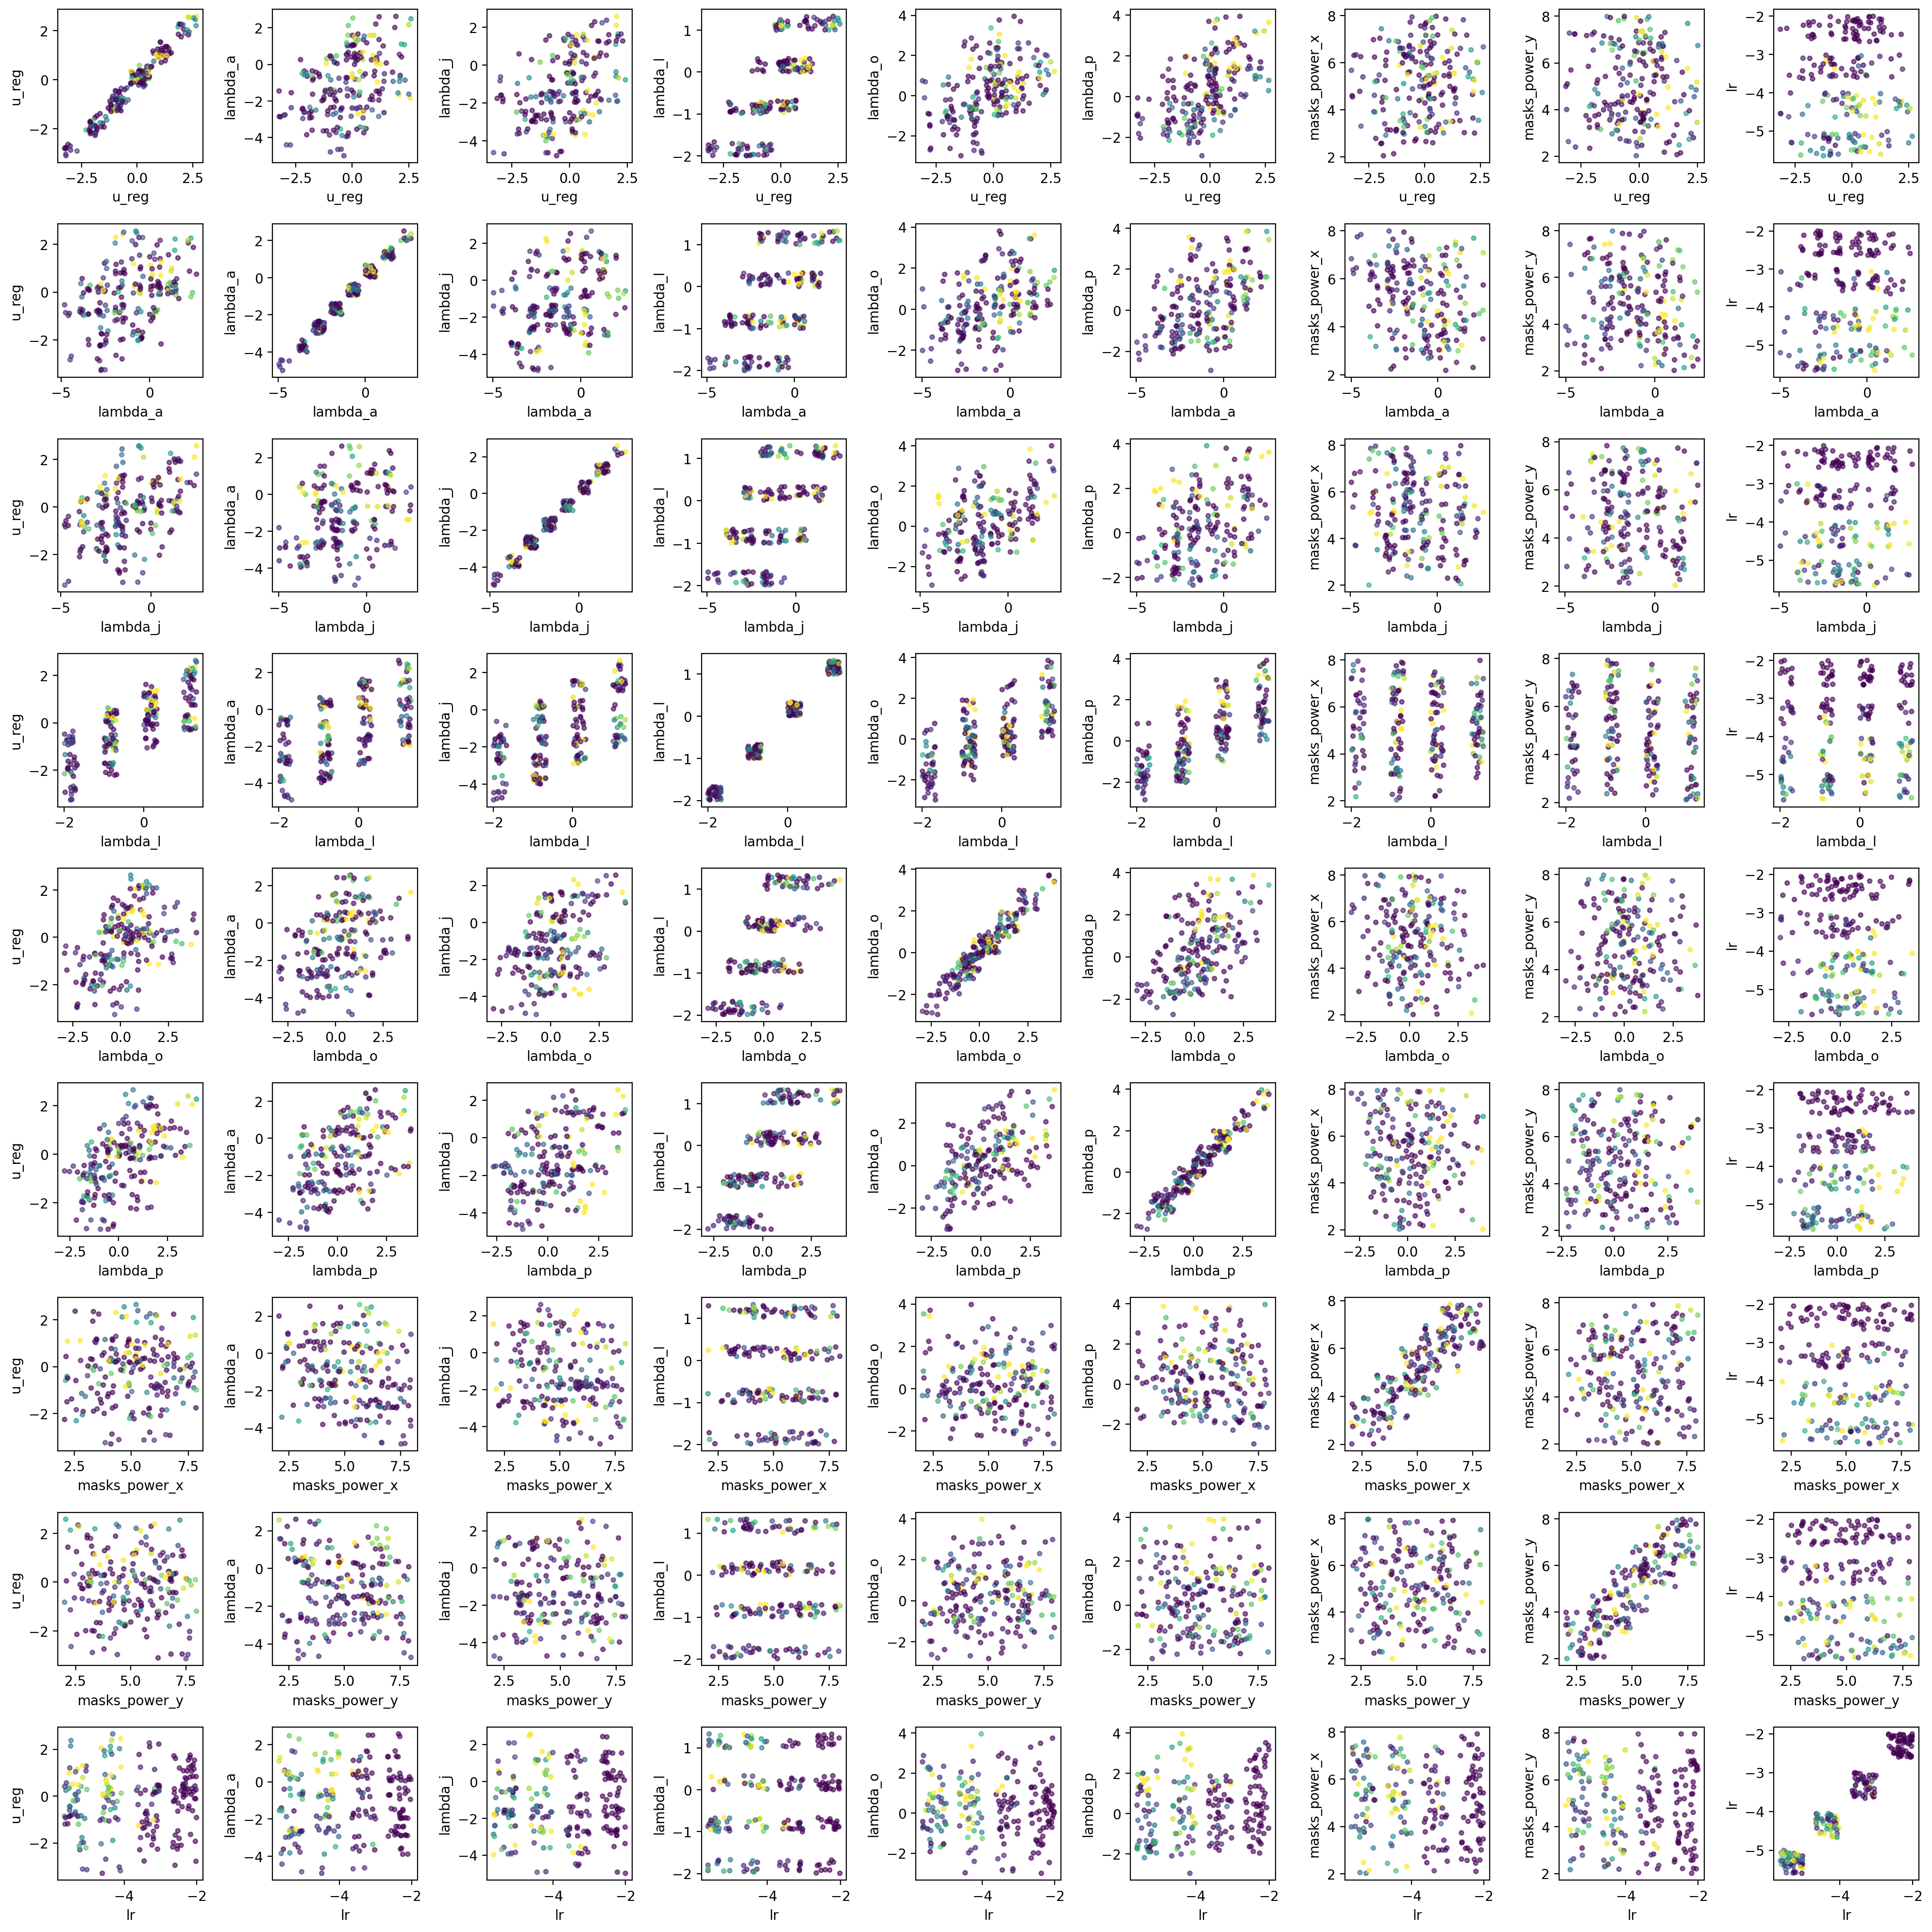

In [167]:
plt.figure(figsize=(20, 20), dpi=200)
for i, x in enumerate(params):
    for j, y in enumerate(params):
        plt.subplot(9, 9, i * 9 + j + 1)
        plot_pair(x, y)
plt.tight_layout()
plt.savefig('params.pdf')